In [1]:
%%html 
<style>code,kbd,pre,samp,.Codemirror{font-family: Menlo, Monaco, Consolas, monospace !important}</style>

In [2]:
from itertools import product
from PIL import Image, ImageOps

import numpy as np, pandas as pd, tensorflow as tf
sess = tf.InteractiveSession()

import matplotlib, seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline
sns.set_style('whitegrid')
matplotlib.rcParams.update({
    'figure.figsize': (10, 6), 'font.size': 16, 'axes.labelsize': 20, 'xtick.labelsize': 12,
    'ytick.labelsize': 12, 'font.family': 'Helvetica,Arial,sans-serif'
})
%config InlineBackend.figure_format = 'retina'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Machine Learning lab 7: convolutional neural networks
## Jake Rowland and Paul Herz
2017-11-20

> **Nota bene:** much of this introductory text that describes the classification task and dataset preparation is replicated from a previous project using the same dataset, so as to avoid unnecessary rewriting. Some of it is partially replicated but modified to reflect necessary differences, whereas others are wholly reproduced.

## 1. Introduction

From Lab 3:
> We sought a dataset with clear and unambiguous classes (pre-labelled). However, to avoid a classification task that was overly-ambitious, a small number of classes was ideal. We settled upon a labelled image dataset containing cats and dogs ([Kaggle](https://www.kaggle.com/c/dogs-vs-cats)).

In the [previous project](https://github.com/SMU-ML-2017/Project3/blob/master/Project3%20ML.ipynb) using this dataset, we never performed a classification task, instead only theorizing about such a task. We only analyzed performance of different Principal component analysis (PCA) methodologies and DAISY feature extraction. It took about 125 principal components to reach 90% cumulative explained variance, and our intra-class feature distance visualizations were difficult to make meaning of.

If we gained something of great use from that project, it was a better understanding of image processing. Since then, we have worked with the rudiments of neural networks, and have had several successful attempts at building passable and easy-to-understand neural networks on top of Keras (Tensorflow backend). In this lab, we will develop a Convolutional Neural Network (CNN) using Keras, and evaluate its performance on the task of visually classifying dogs vs. cats.

### 1.1 Background

*Wholly reproduced from Lab 3*

> Elson, Jeremy, John Douceur, Jon Howell, and Jared Saul. "Asirra." *Proceedings of the 14th ACM conference on Computer and communications security - CCS 07*, 2007. doi:10.1145/1315245.1315291 ([Libre PDF](https://www.microsoft.com/en-us/research/wp-content/uploads/2007/10/CCS2007.pdf)).

This dataset was furnished by Asirra (Animal Species Image Recognition for Restricting Access). Asirra is a CAPTCHA security challenge, i.e. a program designed to bar automated processes from accessing a system by forcing the user to prove their humanity. Asirra was an experiment in making a new and unique type of CAPTCHA, that would be trivial, less frustrating, and endearing to users.

Asirra pulls images of pets from Petfinder, an adoption service. These images are restricted to cats and dogs. Petfinder users have self-labeled these postings as cats or dogs during the upload process. Asirra challenges the user to identify a set of 12 images as either cats or dogs to proceed, and advertises an "Adopt me" button as a quid pro quo for using Petfinder's content.

According to the abstract:
> [Asirra] can be solved by humans 99.6% of the time in under 30 seconds, ... Barring a major advance in machine vision, we expect computers will have no better than a 1/54,000 chance of solving it.

Bear in mind that this was published in 2007. The one in 54,000 figure is an extremely pessimistic estimate, perhaps even a faulty one, as it is an ~8% piece of the probability of guessing randomly on a series of 12 binary choices ($0.5^{12} = 1/4096$). So perhaps even for the time of its writing the figure is extreme, but even the figure for guessing randomly is poor (~0.02%).

There is little doubt that such a statement was interpreted as a challenge to the machine learning community, one that Kaggle worked with the Asirra (Microsoft Research) team to formalize in 2013. Asirra forwarded their dataset to Kaggle, and the "Dogs vs. Cats" challenge has been open ever since. According to Kaggle, classifying cats against dogs in this dataset is nontrivial due to the complexity and heterogeneity of the images:

> There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult

In summary: whereas the original authors posited the success rate could not exceed 1:54000 with the contemporary state-of-the-art (SoA), the more realistic random choice success probability is 1:4096; an outdated poll states that the SoA per-image accuracy was 60% (1:459 success rate); the contemporary SoA for per-image accuracy is 80% (Golle, 2009), equating to a roughly 1:15 success rate (figures from Kaggle and Microsoft Research).

> Golle, P. (2009). Machine learning attacks against the Asirra CAPTCHA. *Proceedings of the 5th Symposium on Usable Privacy and Security - SOUPS 09*. doi:10.1145/1572532.1572585 ([Libre PDF](http://xenon.stanford.edu/~pgolle/papers/dogcat.pdf))

The purpose and worth of this dataset originated as a novel experiment in security controls and automation defeat mechanisms. However, it has become a relatively popular dataset, as well as a barometer of the SoA in image recognition and classification — it stands as a continual challenge to the ML community to further the SoA vis-à-vis this dataset's primary classification task.

### 1.2 Business Case

*Wholly reproduced from Lab 3*

Classifying cats against dogs may not appear to have a business case per se. The academic endeavor that the dataset represents (*vide supra*, as a "barometer") is insufficient too as a viable case. To the original source of this data, Petfinder, there may be minor value to the service in this classification task. Petfinder's user-uploaded postings of adoptable animals are already hand-labeled during the upload process, but there may be a marketable, if not value-adding, "wow" factor to the service being able to automatically classify an animal based on the uploaded photo.

Another more slightly practical business case of this classification to Petfinder specifically would be the ability to integrate said capability into their moderation tools. This is a similar argument to the one we proposed for fraud and spam detection in Amazon comments in a prior assignment — finding discrepancies between the user-provided data and the classification tool as a piece in the pipeline of user content moderation. Any site on the order of size of Petfinder is sure to have staff and resources dedicated to moderation, and it would reduce expense (read "add value") to their moderation workflow if more probably mislabeled or misleading content was floated to the top of moderator's queues for review. The reduction of such incorrect content would "clean up" the site to an extent — user content is inherently chaotic but users want to see clean, well-formatted content. Chiefly, for an algorithm to be able to discern between cats, dogs, and potentially a third, null category, Petfinder could see postings where the user-labeled pet type did not match the photo, and perhaps more quickly regulate postings where there was no animal present in the photo.

We see this second case as being a more viable integration into the business of Petfinder specifically, or animal adoption/listing sites more generally. Provided that the dataset is from Petfinder, and therefore best represents the content *of* Petfinder, we chose to mention the case specifically relative to them. The second business case truly adds value and efficiency to Petfinder's content management, which directly affects the perceived quality of the site.

### 1.3 Serviceability

In recent years, social media platforms specifically and user-content sites more generally have been abused by malicious parties as platforms for illegal commerce or content. In August, 2018, Sen. Rob Portman (R-OH) introduced the [Stop Enabling Sex Traffickers Act of 2017](https://www.congress.gov/bill/115th-congress/senate-bill/1693/text), a bill with an uncontroversial title that controversially holds online services accountable for the content their users post, full stop. The bill has been called vague and can be read widely to encompass all matter of content, not just content pertaining to trafficking. Even if this bill does not become law, it portends a legislative trend toward increasing the liability of online service owners.

Moderation is already a massive task for which larger companies have to hire/contract/outsource thousands of people, and services like Google and Facebook already have machine learning components in their moderation pipeline, not to the exclusion of human eyes. The legal liability and the cost of work to moderate nation or world-scale user-submitted data on a popular website is simply becoming too massive. As such, even a presumably simple site with an everyday purpose like Petfinder is susceptible to these legal and financial pressures.

We believe that on such a site, the volume of material that is irrelevant, obnoxious, or illegal can be very high even if it only accounts for a small percentage of total postings, due to the sheer mass of user-generated content on such a large site. Therefore we believe that a passable and useful detector algorithm should score 99% on our chosen evaluation criteria to be useful - this means humans bear the responsibility of being the sole detectors of 1% of the original load of content, and the other 99% has been flagged already, pointing human moderators toward irrelevant or illegal content with no sifting through general data. That 1% could still be considerable in size, consisting of hundreds of posts in a day, but we believe by cutting down manual flagging by two orders of magnitude, that is sufficient to greatly affect a company's financial and logistical choices towards human content moderation: an operation that requires 1% as much work tends not to resemble the original operation.

### 1.4 Note on compute resources

The effort put into speeding up the iterative process of tweaking and training the CNN put forth by this team is worth documenting. After implementing the CNN model code mostly singlehandedly, Jake Rowland trained the model on the full dataset (25,000 images) flipped (50,000 images) at size 32x32, on his post-2010 MacBook Pro 15-inch. Tensorflow does not support GPU execution on macOS, and the integrated Intel graphics would not work with the required CUDA APIs anyways. CPU-bound, the model took over nine hours to train while CPU-bound, with Keras and Tensorflow.

Paul determined that this wait time was unacceptable, but it would also be unacceptable to subsample the dataset except when testing other aspects of the experimentation code, since the upper limit of model generalization performance seemed pegged to dataset size rather than (to an extent) hyperparameters and architecture. He rebuilt a computer from parts and installed Ubuntu 17.10 on it, with CUDA, cuDNN, `tensorflow-gpu`, and it became the team's Jupyter server, henceforth, the "workstation." In a standard Tensorflow training and prediction benchmark, the workstation performed eighty times (80x) faster than a laptop. The laptop being a consumer grade 2016 MacBook Pro running Tensorflow not compiled for CUDA or extended SIMD support, whereas Tensorflow does not support Mac GPUs anyways. **The nine-hour training task Jake underwent earlier was reduced to about one hour.** For reference and as a minimum requirements recommendation to reproduce the results of this report, the system specifications are given below:

The specifications of the workstation are as follows:
- NVIDIA GeForce GTX 980 GPU (4981 GFLOP, 2048 shading units)
- Intel Core i7-6700K CPU (207.23 GIPS, 4-4.2GHz variable, SSE4.1/4.2, AVX2)
- 16GB DDR4 RAM (2x8GB)
- An SSD is recommended for dataset loading and archive storage but not required

One shortcoming of our setup is that, after about four hours trying to compile `tensorflow`, notably the hardest thing to compile from source ever, we gave up and installed `tensorflow-gpu` from `pip`. This supported the compiled CUDA 8.0 and cuDNN 6.0 on system, but with more effort, or by using unofficial binaries from other machine learning organizations on Github, we could've sped up execution and reduced the CPU bottleneck by supporting SIMD extensions that the CPU on system supported. Additionally, `tensorflow` can be compiled with support for the proprietary Intel Math Kernel Library, an Intel-specifically optimized library that also contributes to reducing any CPU bottlenecks in a GPU-centric Tensorflow execution environment. Paul documented his process for setting up CUDA, cuDNN, and attempting to build `tensorflow` from source, but those procedures need refinement and further research, though we will probably keep using the `pip`-distributed binary for the remainder of the semester.

## 2. The dataset: preprocessing and review

### 2.1 Dataset preparation

This time around, we took a more advanced approach to dataset preparation and image processing to expedite the process of preparation and avoid any bad habits. First, when working on dataset subsamples (rather than all 25K images), we used to just load the first $n$ files. Now, we load a random selection of files from the whole dataset, to make sure we are always seeing a completely new sample each time, rather than the same 1,000 or 10,000 files when subsampling.

Loading the image files for the dataset took a considerable amount of time, maybe even longer than the process of scaling or converting the images. Paul undertook a process to make dataset loading more efficient. His theory was that there was considerable overhead in loading 25K individual files rather than one large archive: for instance, loading the dataset file-by-file onto our server took considerably longer than loading a single .tar or similar archives, even uncompressed ones. As such, in the code below, we only load all 25K image files once, to build a single archive file consisting of all images downscaled to the desired size `image_size` and converted to 8-bit grayscale. This is not only faster because subsequent use of the dataset just loads the resulting single numpy archive file, but because all expensive and repetitive preprocessing (scaling, grayscale) happen only once. A process that takes up to a minute on a powerful workstation takes less than a millisecond once the archive file has been created. The original dataset is roughly half a gigabyte, whereas the final 50x50 pixel dataset archive (`dogs_vs_cats.npz`) is 57MB, including class labelling.

We do not, however, perform normalization before saving the images in the archive, as this would unnecessarily multiply the size of the dataset by a factor of 8 on disk (as normalization requires conversion from `uint8` to `float32`). The extant problem was, however, that normalization was also slow and repetitive. It only consisted of two operations: division by 127.5 and subtraction by 1 to map the range 0...255 to -1...1, but it took around 10 seconds on our workstation each time. Paul rewrote the normalization function in raw Tensorflow, which on a consumer laptop tripled the speed (on CPU) and on our workstation, made normalization 10x faster (on GPU). The two normalization functions were tested for time performance and correctness (relative error) in a special test script before using the new Tensorflow implementation.

#### Note on Expansion

25K images is a lot (to us), but we hit a ceiling on generalization performance that could not be raised through model tweaking. We mirrored the entire dataset across the y-axis ("horizontal mirroring") to give us a dataset of 50K images, which finally allowed us to achieve scores in the high 90s. As such, we can empirically state that data expansion did help us achieve greater performance, although we would still like to experiment with further expansion, such as random distortion and skewing, as mirroring only doubles the available data.

#### Dataset preparation: implementation

Below is the code that loads all 25K images one by one, performs downscaling (in a way that preserves aspect ratio but covers the 50x50 canvas), converts images to an 8-bit grayscale color space, and archives each image along with its class label in a numpy binary archive (`.npz`) file. It does compress the `.npz` file, an optional feature, but we found this did not save *that much* space (~2%). However, it did not introduce a significant delay in reloading. We had tried using HDF5 through Pandas and Numpy, but it proved to be finicky and incapable of storing DataFrames that contained numpy arrays without using `pickle`. We have been trying to avoid `pickle` after unfortunately finding out about the incompatibility between the `pickle` v2 and v3 formats, which we experienced when trying to use a dataset prepared in Python 3, with CoreML tools in Python 2. The numpy-specific binary format seems pain free, and the numpy archive format being able to contain multiple named arrays is an added bonus, reducing the number of files in the project repository (most of the files are backups of experiments with different image sizes, etc.)

In [4]:
import os.path
import random

def generate_dataset_archive(overwrite=False):
    '''
    load all images data/cat.{i}.jpg and data/dog.{i}.jpg
    for i in 0...12499 inclusive, then downscale to
    image_size and archive as a compressed .npz file.
    
    expects you to have extracted the dogs vs. cats
    dataset from kaggle into a folder underneath this
    notebook called data. it consists of 25000 JPEG images.
    '''    
    archive_name = 'dogs_vs_cats.npz'
    file_prefix = 'data/'
    PIL_GRAYSCALE_MODE = 'L'
    images = []
    labels = []
    images_per_class = 12500
    
    archive_exists = os.path.isfile(archive_name)
    if not overwrite and archive_exists:
        print(f'The archive file {archive_name} already exists.\nSkipping data processing.\n')
        return
    elif overwrite and archive_exists:
        print('Processing data and overwriting to archive file...')
    else:
        print('Processing data and creating new archive file...')
        
    print(f'Loading {images_per_class*2} images and compressing to size {image_size}')
    
    for pet_type, index in product(['cat','dog'], range(images_per_class)):
        file_name = f'{pet_type}.{index}'
        image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=PIL_GRAYSCALE_MODE)
        image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
        data = np.array(image.getdata())
        
        is_dog = (pet_type == 'dog')
        images.append(data)
        labels.append(is_dog)
    
    # numpy archive (.npz) of multiple objects
    np.savez_compressed(
        archive_name, 
        data=np.array(images,dtype=np.uint8), 
        target=np.array(labels,dtype=np.bool_)
    )
    print('Saved.')
    print()

Here is our normalization code, with the aforementioned Tensorflow implementation (process described above). It uses an `InteractiveSession` started at the beginning of the notebook, which is notably the only overhead of TF over numpy. `flip_bitmap` flips a single image matrix by first reshaping an initially flat image into square form again, flipping it, and then putting it back to linear form. `flip_dataset` returns a doubled dataset, aka a normal dataset with a flipped dataset appended to it.

In [160]:
## numpy method (slow, CPU bound)
# def normalize_scalar(x):
#     return 2*((x/255)-0.5)
# normalize = np.vectorize(normalize_scalar, otypes=[np.float32])
# def normalize(data):
#     print('Mapping int8 data [0,255] to float32 [-1,1]\n')
#     _normalize_scalar=lambda x:2*((x/255)-0.5)
#     _normalize=np.vectorize(_normalize_scalar,otypes=[np.float32])
#     return np.apply_along_axis(_normalize, 0, data)

# tensorflow (11x faster on GPU)
def normalize(data):
    print('Mapping int8 data [0,255] to float32 [-1,1]\n')
    tensor = tf.convert_to_tensor(data, np.float32)
    tensor = tensor/127.5 - 1
    return tensor.eval()

def flip_bitmap(data):
    data = data.reshape(image_size)
    data = np.fliplr(data)
    return data.flatten()
flip_all_images = np.vectorize(flip_bitmap, otypes=[np.float32])
    
def flip_dataset(data,target):
    data_flipped = np.copy(data)
    data_flipped = np.apply_along_axis(flip_bitmap, 1, data_flipped)
    return np.vstack((data,data_flipped)), np.concatenate((target,target))

Below is the code to load the dataset archive prepared earlier, with additional code to randomly subsample it, flip it in memory, and most importantly, normalize it. Throughout the dataset preparation and loading process, careful attention was paid to speeding up operations that could be sped up, and saving to file work which could not be expedited. Just as the archive is saved above, it is loaded here and contains two labelled arrays: `data` (the image data in `uint8` grayscale) and `target` (a 1D vector of booleans for `is_dog`)

In [161]:
def load_dataset_archive(sample=None, flip=False):
    '''
    pick a random sample from the total population of images.
    create horizontally mirrored duplicates of all source images
    if requested.
    '''
    archive_name = 'dogs_vs_cats.npz'
    ds = np.load(archive_name)
    
    image_count = ds["data"].shape[0]
    sample_count = image_count
    print(f'Loaded archive with a total of {image_count} images.')
    
    if sample is None:
        print(f'No sampling - using full dataset ({image_count} images)')
        data = ds['data']
        target = ds['target']
    elif 0.0 > sample < 1.0:
        raise ValueError('Sample rate must be between 0 and 1')
    elif sample is not None:
        sample_count = int(sample * image_count)
        if sample_count == 0:
            raise ValueError(f'A sample rate of {sample} yields a zero-sized sample!')
        print(f'Randomly sampling {sample*100}% of the dataset ({sample_count}/{image_count})')
        sample = random.sample(range(image_count), sample_count)
        data = ds['data'][sample]
        target = ds['target'][sample]
        
    if flip: 
        print(f'Flipping to double dataset ({sample_count*2} images)')
        data, target = flip_dataset(data, target)
    print()
    return data, target

Below we decide the constant image size for the whole experiment, whether to double the datset through horizontal mirroring, and whether to subsample the dataset or use the whole thing (`None`, no subsampling).

In [3]:
image_size = (50, 50) # Size for all images
flip_images = True    # Double the dataset by mirroring it?
dataset_sample = None # How much of the dataset do we want? (None = don't subsample)

In [5]:
# Loading the whole dataset from individual image files
# (25,000 images total) is very slow. This function
# generates a numpy archive (.npz) of the downsized grayscale
# images if it doesn't already exist. This saves time when
# rerunning the notebook.
%time generate_dataset_archive()

The archive file dogs_vs_cats.npz already exists.
Skipping data processing.

CPU times: user 214 µs, sys: 98 µs, total: 312 µs
Wall time: 216 µs


In [6]:
print('LOADING + EXPANSION\n','—'*50,sep='')
%time data_raw, target = load_dataset_archive(sample=dataset_sample, flip=flip_images)

print('\nNORMALIZATION\n','—'*50,sep='')
%time data = normalize(data_raw)

print('\nimages stored as dtype',data.dtype)
print(len(data),'images,',image_size,'pixels each')

if data[0].shape[0] != image_size[0]*image_size[1]:
    print('WARNING: the loaded/generated data is a different size than defined')
    print('by `image_size`.')

mem = data.nbytes
print('RAM usage:',mem/1000000.,'MB')

LOADING + EXPANSION
——————————————————————————————————————————————————
Loaded archive with a total of 25000 images.
No sampling - using full dataset (25000 images)
Flipping to double dataset (50000 images)

CPU times: user 693 ms, sys: 105 ms, total: 798 ms
Wall time: 791 ms

NORMALIZATION
——————————————————————————————————————————————————
Mapping int8 data [0,255] to float32 [-1,1]

CPU times: user 1.66 s, sys: 1.33 s, total: 2.99 s
Wall time: 2.07 s

images stored as dtype float32
50000 images, (50, 50) pixels each
RAM usage: 500.0 MB


### 2.2 Data quality

The original dataset really only had two properties: image data, represented by file contents, and image names, represented by file names. The images names, in turns, had unique combinations of number IDs (0...12499) and class names ("cat" or "dog"). To simplify the archiving process described above, the numerical IDs were discarded, and the only archived data consisted of image bitmaps (under the `data` key) and binary classification (`0` for cat, `1` for dog under the `target` key). As such, the below "gallery" does not include image indices.

One of the most notable issues we found in Lab 3 (link in the introduction) was the inconsistency among the images. Unlike tabular or textual datasets, where data can be outright missing or obviously garbled, some of this data was just subjectively poor photography in the human eye, or it had been unnecessarily adorned with kitschy graphics, such as masking images to circles, stars, hearts, etc., overlaying pet's names, or long paragraphs written (allegedly) by the pet themselves, describing their tough upbringing but winning personality (really). Some images have multiple animals in them, some of them have cats *and* dogs in them, some of the images even contain humans. Beyond that, inconsistent lighting, framing of the subject, focus, pose, setting, breed, fur color, and (mainly for dogs) inconsistent facial shape makes the process of teaching on this dataset inherently difficult.

However, there's no such thing as a perfect dataset, nor would we want such a dataset: this data is human generated and very much "real-world." It's raw, dirty, and perfect for seeing if this classification task is doable with real data.

In [7]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

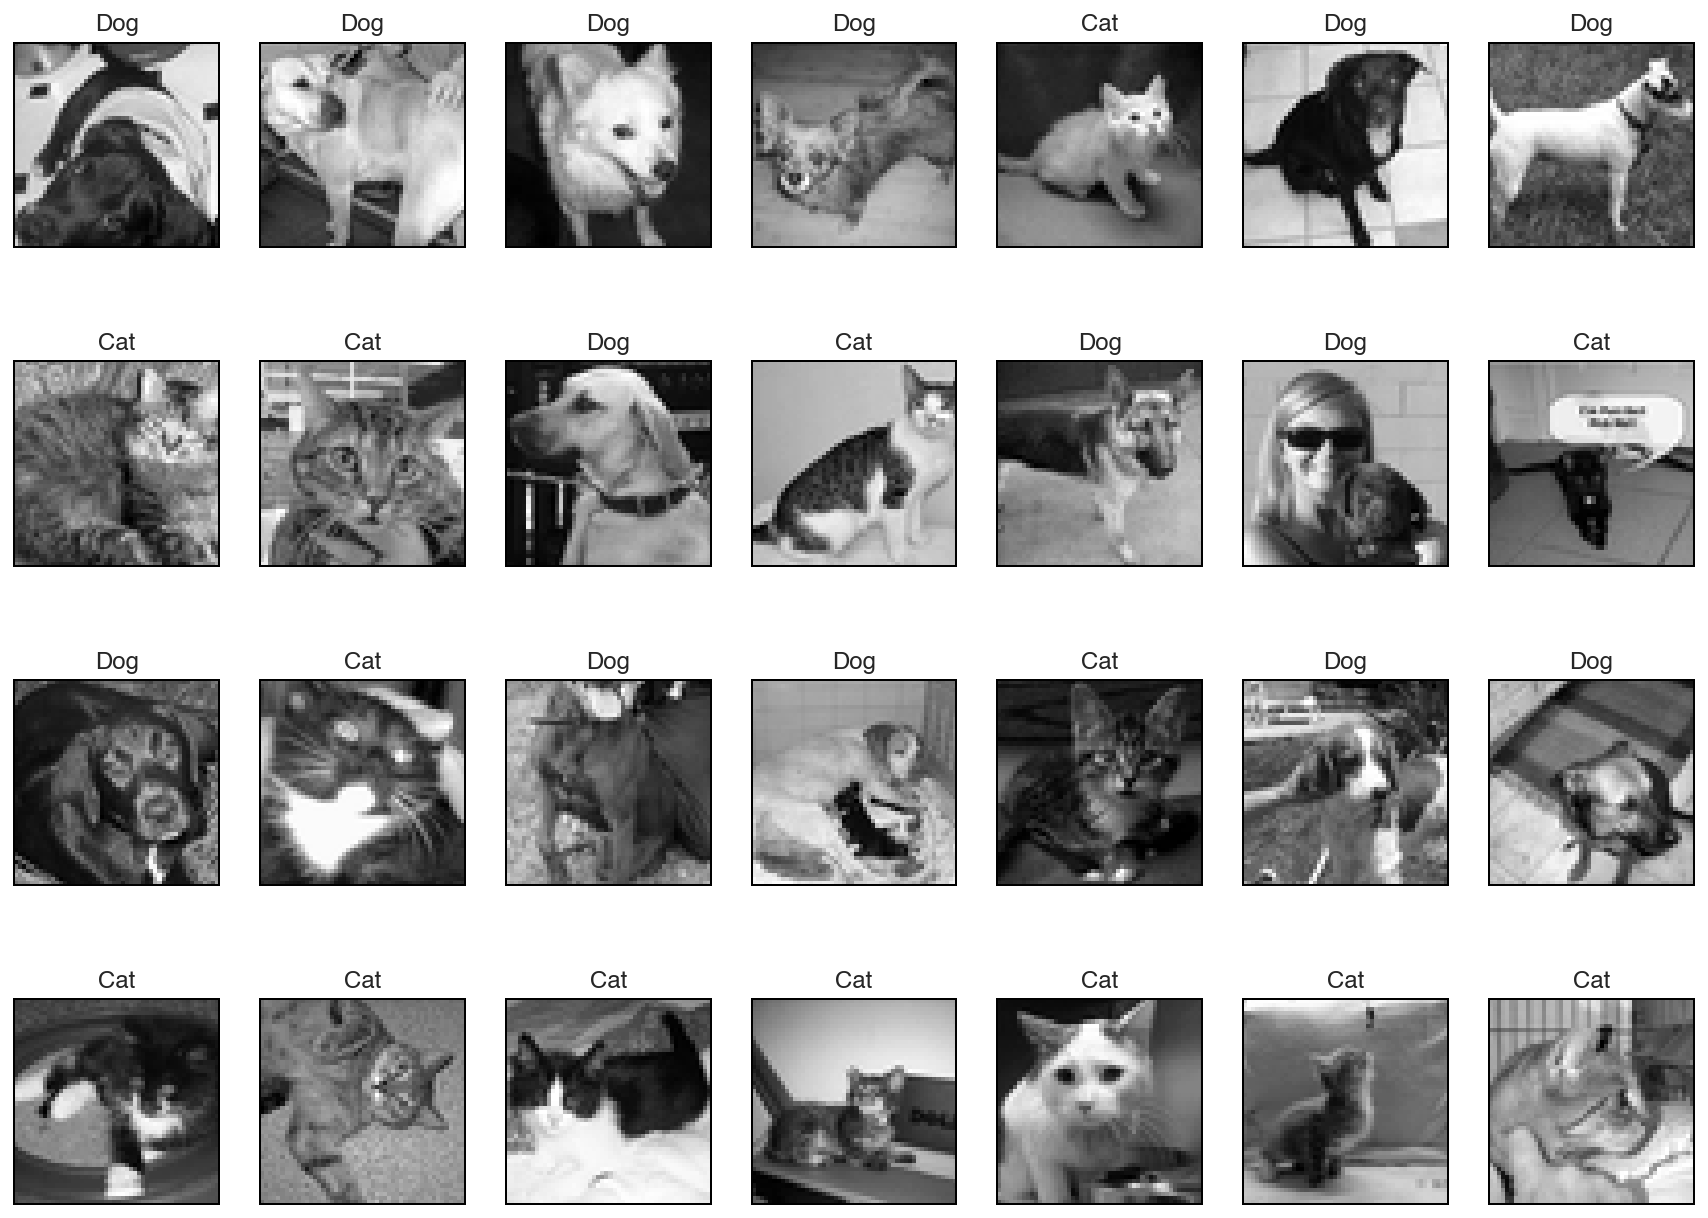

In [159]:
gal = (4, 7)
idx = np.random.choice(data_raw.shape[0], gal[0]*gal[1], replace=False)
some_images = data_raw[idx]
some_labels = np.vectorize(lambda x: 'Dog' if x else 'Cat')(target[idx])
plot_gallery(some_images, some_labels, image_size, rows=gal[0], cols=gal[1])

### 2.3 Final state of the dataset

In this project, we modify the dataset in several stages.

1. **During image file loading:** we shrink the images and convert them to grayscale. We store all the images as flat rows in a single matrix, which along with class labels (derived from filenames) is archived in numpy binary format, in 8-bit grayscale format.

2. **During archive loading:** that archive is reloaded in a very short amount of time. The dataset is converted from 8-bit integer to 32-bit floating point format in a computationally cheap but memory-space expensive operation (which is why it is not archive in float format). The 8-bit color gamut is normalized to -1...1 at this point.

3. **Inside the model during `fit()`** Images are reshaped to square form so that they can be convolved and `target` (class labels in the form of `is_dog` booleans) are converted to one-hot encoding so that loss can be properly optimized.

4. **Inside the model after `predict()`** Contrary to expectation, predict() does not return one-hot encoded classification data, but floats. To do otherwise would make cross-validation difficult. One-hot encoding is opt-in through a static-function, which makes the data useful for actual prediction as well as discrete evaluation methods like confusion matrices.

However, this is a glimpse at the current format after step two but before fitting:

In [168]:
data[0] # a single flattened image, normalized to -1,1

array([ 0.60000002,  0.6156863 ,  0.63921571, ..., -0.87450981,
       -0.90588236, -0.92941177], dtype=float32)

In [169]:
target # all class labels (as booleans representing whether it is a dog or not)

array([False, False, False, ...,  True,  True,  True], dtype=bool)

## 3. Evaluation, training, and testing
### 3.1 Evaluation criteria

Our choice of primary evaluation criteria (not barring other criteria in certain visualizations) is based on two components: what we have to use elsewhere, and what is most faithfully representative of generalization performance with regard to our business case. We are required to compare performance of a standard Multi-Layer Perceptron (MLP) to our Convolutional Neural Network (CNN) using ROC/AUC as our metric, so we were already inclined to use it generally throughout the project to make sure all model comparisons could be apples-to-apples.

As to the second component, we think ROC/AUC works well because it visualizes (ROC) and quantifies (AUC) across a spectrum of operation scenarios rather than just outputting a single score: it demonstrates "sensitivity as a function of specificity." Additionally, we do not need to expand upon single AUC calculation for this binary classification problem (as opposed to per-class AUC in a one-versus-many format).

In [170]:
from sklearn.metrics import roc_auc_score
evaluation_function = roc_auc_score

### 3.2 Cross validation methodology

We believe Stratified 10-fold cross validation to be an accurate reflection of the real-life environment into which this algorithm would be integrated. We are not retroactively analyzing a full dataset all at once, although we would be able to train our classifier on all of Petfinder's data initially, as per our business case. After that, however, smaller segments of live user-submitted data would accumulate, so being able to determine how much new data alters performance (by rotating the training set by 10% at a time) is important. Overall, this CV methodology lends us greater perspective on model performance in different data scenarios.

Unlike with `scikit-learn` models, we do not use the built in cross validation tools directly, such as `cross_val_score`. We *do* use a cross validation index generator, here `StratifiedKFold`, to generate indices for each fold, but that is fed through a custom-made cross validation suite that works specifically with features of our CNN to expose extra data, such as accuracy/loss over each epoch. It may be overkill, but it allows us to visualize the purpose of a certain number of epochs, and allows closer tweaking and inspection of our model. As you will see later, `skfold`, an instance of a CV generator from `scikit-learn`, will be fed into our internal tool, named `CrossValidation`, which is an object so it can maintain internal state between runs and reduce boilerplate code.

In [171]:
from sklearn.model_selection import StratifiedKFold

n_splits = 10
skfold = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)

## 4. Modeling

### 4.1 Our Convolutional Neural Network (CNN)

Many of the design decisions made here resemble and evolve upon those made in the previous project (Lab 5), where we first established a clean and safe pattern for encapsulating model code inside of a class for ease of use and reduction of repetitive code while in use. As a consequence, the code for the class itself is longer than in a simple procedural design approach, but this code is easier to reuse and understand. We follow the general functional standards and trends that `scikit-learn` and `keras` both follow for their model classes.

The earlier Dataset Preparation section describes how this class does some of the heavy lifting for dataset preparation inside of its `fit()` and `predict()` functions to reduce unnecessary outside preparation boilerplate code, mainly dealing with format conversion (categorical/boolean to one-hot) and shape compatiblity (reshaping flattened images to apply convolutions). Another benefit of this class-based design is being able to clearly separate the many components of the network: `_make_model()` is called at the end of the class initializer, and, using the just-defined model properties, calls `_make_convolution_layers` and `_make_dense_layers` to produce the two sequential components of the CNN, based on the user-provided parameters for kernels, filters, layer sizes, and activation functions. The fact that most if not all parameters of the CNN can be tweaked through the initializer allow us to experiment in greater quantity and more quickly, rather than having to rewrite procedural code that defines the network many times. This enablement of rapid model iteration has allowed us to find some pretty performative architectures and dataset preparations.

As in the previous assignment, this implementation diverges from and expands upon the standard by exposing an `epoch_log_` property which is filled at the end of each epoch using an internal implementation of a keras `Callback`, bound to the epoch end event. This same event is used to increment our custom progress bar on `verbose=3` mode.

#### An obsessive note on progress bars

One of the less-than-intuitive parts of the code to read is in `fit()`, where there is much ado about `tqdm`. The default Keras progress bar restarts on a new line for each epoch, which is painful when you are running 40 epochs in a Jupyter notebook rather than in a terminal you can clear. User experience is an oft-ignored component of machine learning, since the users are data scientists, but after some research, we found a way to have a single progress bar count down all the epochs. `tqdm` is a lovely progress bar that (most importantly) estimates time per iteration using rolling averages and estimates remaining time, which can be useful for hour long processes. It prints to `STDERR` and uses carriage returns to rewrite itself on the same line with new progress values. Unfortunately, this last aspect fails in Jupyter, which not only redirects STDOUT and STDERR to its web UI, but does a poor job of emulating a TTY. 

As such, `tqdm` rewrites its progress bar on the next line at every iteration, which makes it nearly useless. The `tqdm` team refuses to support `jupyter` with its default command line implementation due to the quirkiness of the `jupyter` web UI console, and recommends their `tqdm-notebook` variant, which is a Jupyter notebook widget using Javascript. Unfortunately, although these HTML progress bars are beautiful in the notebook as it runs, they render as error messages in any `jupyter` kernel without notebook widgets enabled, and in `nbviewer` or on Github, the same error messages litter the page. Instead, Paul found `IPython.core.display.clear_output()`, a special jupyter-internal command which wipes a cell's output. The model below, when put into special verbosity mode `3` (three), will use a `tqdm` progress bar to count down the epochs, and if it detects itself to be running in a Jupyter notebook, will use the special `clear_output` command to make sure the progress bar stays on one line. When run in a normal, sensible terminal, `tqdm`'s carriage return method works as expected and `clear_output` is not used or imported. This may, once more, seem like overkill, but Jupyter's inability to handle basic progress bars became one design-focused team member's white whale. So, if you re-execute this notebook, we hope you enjoy the progress bar.

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape, Dense, BatchNormalization,\
Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import Callback
from tqdm import tqdm

try:
    from IPython.core.display import clear_output
    is_ipython = True
except ImportError:
    clear_output = lambda *args: None
    is_ipython = False

class ConvolutionalNeuralNet:
    def __init__(
        self,
        input_shape,
        n_filters,
        dense_sizes,
        output_size,
        
        batch_normalize = True,

        layer_activation='relu',
        final_activation='softmax',

        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=50,
        shuffle=False,
        verbose=2,
        epoch_callback=None
    ):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.dense_sizes = dense_sizes
        self.output_size = output_size
        
        self.batch_normalize = batch_normalize
        
        self.layer_activation = layer_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self.epoch_callback = epoch_callback
        
        self._make_model()
    
    def _make_convolution_layers(self):
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
                       
        for filters in self.n_filters:
            # Add a single convolution layer
            self._model.add(
                Conv2D(
                    filters=filters,
                    kernel_size=(3,3),
                    padding='same',
                    activation=self.layer_activation
                )
            )
            # Add batch normalization to the convolution layer
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
            # Pool the layer
            self._model.add(
                MaxPooling2D(pool_size=(2,2), data_format='channels_first')
            )
        
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
        for size in self.dense_sizes:
            self._model.add(
                Dense(size, activation=self.layer_activation)
            )
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
        self._model.add(
            Dense(self.output_size, activation=self.final_activation)
        )
                
    def _make_model(self):
        self._model = Sequential()
        
        self._make_convolution_layers()
        self._make_dense_layers()
        
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        progress_bar = None
        if self.verbose == 3:
            progress_bar = tqdm(total=self.epochs)
        
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
                if net.verbose == 3:
                    clear_output()
                    progress_bar.update(1)
                if net.epoch_callback is not None:
                    net.epoch_callback(epoch)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose if self.verbose != 3 else 0,
           callbacks=[AnalyticsCallback()]
        )
        if self.verbose == 3:
            progress_bar.close()
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


Giant blocks of code like the one above beg the question of Jupyter notebook etiquette: "at which line count do we move code to a separate .py file?"

Below is our custom implementation of Cross Validation, which relies on a `cv` object being fed into the initializer to generate our cross validation indices and make other decisions about stratification and shuffling. This object is a `scikit-learn` cross validation object such as `StratifiedKFold` that really can be any object, from `scikit-learn` or otherwise, that exposes a `split(X,y)` function (thanks to Python's duck typing). This function returns a tuple of arrays, the first of which is the set of training indices, the second being testing indices. `data` and `target` (our X and y, images and labels) are separate but index-aligned, meaning the zeroth image corresponds to the zeroth label et cetera, so it is compatible with this direct indexing methodology.

After constructing a `CrossValidation` object by passing in a cross validation index generator, you call `run(ModelClass, parameters, data, target)`, which will preform k-fold cross validation depending on the parameters provided to the cross validator. (We construct our cross validation generator, `skfold` above, adjoining the rationale on Stratified 10-fold CV). `run()` in turn generates all $k$ rounds of indices and iteratively calls `_step`, which is one of $k$ cross validation steps. We failed to parallelize this unfortuately long-running task due to parallelization issues in Keras and Tensorflow, but due to the all-consuming nature of this computation task, parallelization on a single platform may have actually *lowered* computational efficiency due to resource battling and general overhead. So this CV approach is about as efficient as we can attain without a distributed computing cluster, for which we would just modify this approach to spawn and assign jobs to the distributed task pool (through some messaging protocol) rather than executing them sequentially and synchronously on this platform.

In [10]:
from tqdm import tqdm

try:
    from IPython.core.display import clear_output
except ImportError:
    pass
    
class CrossValidation:
    def __init__(self, cv, verbose=False):
        self.cv = cv
        self.verbose = verbose
        self.progress = None

    def run(self, ModelClass, parameters, data, target):
        cv_indices = self.cv.split(data, target)
        scores = np.empty(n_splits)
        nets = [None]*n_splits

        if 'epochs' in parameters:
            total_epochs = n_splits*parameters['epochs']
        if self.verbose:
            self.progress = tqdm(range(total_epochs),ncols=70,unit='epoch')
        for i,indices in enumerate(cv_indices):
            scores[i],nets[i] = self._step(ModelClass, parameters, indices, data, target)
        return scores,nets
    
    def _step(self, ModelClass, parameters, indices, data, target): 
        train_index, test_index = indices
        X_train = data[train_index]
        y_train = np.asarray(pd.get_dummies(target[train_index]))
        X_test = data[test_index]
        y_test = target[test_index]
    
        up = self._update_progress
        def make_epoch_handle():
            def epoch_handle(epoch):
                up()
            return epoch_handle

        if 'epoch_callback' in parameters and self.progress is not None:
            parameters['epoch_callback'] = make_epoch_handle()

        # training
        clf = ModelClass(**parameters)
        clf.fit(X_train, y_train)

        # testing
        y_hat_raw = clf.predict(X_test)
        y_hat = ModelClass.one_hot_output(y_hat_raw)
        score = evaluation_function(pd.get_dummies(y_test), y_hat)
        return score,clf
    
    def _clear(self):
        try:
            clear_output(wait=True)
        except AttributeError:
            pass
    
    def _update_progress(self):
        self._clear()
        self.progress.update(1)
    
    @staticmethod
    def get_logs_from_nets(nets, parameter_name):
        return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

Below we instantiate our `CrossValidation` object using the `skfold` variable from earlier in the report (representing Stratified 10-fold CV). This one object will be reused to ensure consistency in cross-validation.

In [ ]:
cv = CrossValidation(skfold, verbose=True)

What follows is some code to graph evaluation criteria (ROC/AUC) scores across all folds in a bar chart (with the capacity to compare several networks' performance across parallel but not identical folds side-by-side), as well as a function that acts as a sort of "continuous box plot," plotting a line representing an average surrounded by an area of variable thickness bounded by the lower and upper quartiles. If that does not make sense, you will see it below. When our epoch count went above 30, the boxes in our box plot were too small to be meaningful when looked at briefly, which is why we designed this graph (we certainly didn't invent it, but we coded it from scratch).

In [151]:
def graph_cv_compare(score_sets, names=range(10), colors=None):
    ax = plt.gca()
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_folds = len(score_sets[0])
    n_items = len(score_sets)
    x = np.arange(n_folds)
    width = 1/(n_items+1)
    offset = width*0.5*(n_items+1)
    space = np.linspace(-1, 1, n_items+2)[1:-1]
    for index in range(n_items):
        x_offset = x + space[index]*offset
        plt.bar(x_offset,score_sets[index], width=width, label=names[index], color=colors[index])
    plt.xticks(range(n_folds),range(1,n_folds+1))
    plt.title(f'Stratified {n_folds}-fold cross validation')
    plt.xlabel('fold #')
    plt.ylabel('score')
    plt.ylim(0,1)
    plt.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
    print('\n','='*50,'\nAccuracy (ROC)\n',sep='')
    for index in range(n_items):
        print(f'{names[index]}: {np.asarray(score_sets[index]).mean():0.2} '
              f'(±%{np.asarray(score_sets[index]).std() * 2:0.2})')
    print('='*50,'\n')
# https://gist.github.com/phrz/98045738d182dd75d1eed74470b9b2ef
def average_line(data, plot_quartiles=True, color='#016d91'):
    '''
    Given 2D data where columns are samples and rows are classes/time series, 
    plot an average line and surrounding quartile area 
    (like a continuous box plot)
    '''
    averages = np.average(data,axis=0)
    x = np.arange(1, len(averages)+1)
    plt.plot(x, averages, color=color)

    if plot_quartiles:
        lower = np.percentile(data, 25, axis=0)
        upper = np.percentile(data, 75, axis=0)
        plt.fill_between(x, lower, upper, color=color, alpha='0.25', linewidth=0)

### 4.2 Model comparison: CNN Architecture 1

What follows is the CNN model whose parameters we spent the most time tuning, and we believe to be our best performing model. We define the parameters, which we feed into our reusable `CrossValidation` instance along with our model class name. This model architecture consists of 5 convolutional layers of increasing size followed by two dense layers. We found 40 epochs to be the "sweet spot" where accuracy was still improving, but beyond which was a waste of computational effort due to minimal gains in accuracy. On our workstation, training this model ten times in Stratified 10-fold CV, with 50,000 50x50 images took about an hour. This code saves the score results (binary accuracy across epochs, loss across epochs, and per-fold ROC AUC after training) to an archive file, as do later model comparison sections for efficiency and in case of Jupyter kernel termination.

Visualization will follow after the three networks we are comparing in combined charts to reduce redundant charting and the overall length of this report.

In [172]:
params = dict(
    input_shape=image_size,

    n_filters=[32,64,64,256,256],
    dense_sizes=[128,128],

    output_size=2,

    loss='binary_crossentropy', 
    optimizer='Nadam', 
    metrics=['binary_accuracy'],

    batch_size=32,
    epochs=40,
    shuffle=True,
    verbose=0,
    epoch_callback=None # do not remove
)

In [175]:
# Just for visualization, CrossValidation makes its own instance.
_ = ConvolutionalNeuralNet(**params)
print('This diagram is sequential top-to-bottom.')
_._model.summary()

This diagram is sequential top-to-bottom.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 1, 50, 50)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 1, 50, 32)         14432     
_________________________________________________________________
batch_normalization_95 (Batc (None, 1, 50, 32)         4         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 1, 25, 16)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 25, 64)         9280      
_________________________________________________________________
batch_normalization_96 (Batc (None, 1, 25, 64)         4         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None

In [13]:
import os.path
archive_name = 'cv_result_50k_50_50_10f_roc.npz'
archive_exists = os.path.isfile(archive_name)

if not archive_exists:
    print('Results could not be loaded. Performing CV from scratch.')
    scores, nets = cv.run(ConvolutionalNeuralNet, params, data, target)
    accs = CrossValidation.get_logs_from_nets(nets, 'binary_accuracy')
    np.savez(archive_name, scores=scores, accs=accs)
else:
    print('Archived results found on disk. Reloading.')
    print(f'(to perform CV from scratch, delete {archive_name})')
    ds = np.load(archive_name)
    scores, accs = ds['scores'], ds['accs']

Archived results found on disk. Reloading.
(to perform CV from scratch, delete cv_result_50k_50_50_10f_roc.npz)


### 4.3 Model comparison: CNN Architecture 2

What follows is a second CNN architecture with arbitrary tweaks made to the prior architecture leading to fewer and smaller convolutional layers and twice as many dense layers, to understand the balance between the need for both components and to see the tradeoff. The remaining parameters are identical. We found this model to be less computationally efficient on our workstation by a factor of about 20%.

In [24]:
cnn2_params = dict(
    input_shape=image_size,

    n_filters=[32,64,64,128],
    dense_sizes=[128,128,128,128],

    output_size=2,

    loss='binary_crossentropy', 
    optimizer='Nadam', 
    metrics=['binary_accuracy'],

    batch_size=32,
    epochs=40,
    shuffle=True,
    verbose=0,
    epoch_callback=None # do not remove
)

In [25]:
import os.path
archive_name = 'cnn2_cv_result_50k_50_50_10f_roc.npz'
archive_exists = os.path.isfile(archive_name)

if not archive_exists:
    print('Results could not be loaded. Performing CV from scratch.')
    cnn2_scores, cnn2_nets = cv.run(ConvolutionalNeuralNet, cnn2_params, data, target)
    cnn2_accs = CrossValidation.get_logs_from_nets(cnn2_nets, 'binary_accuracy')
    np.savez(archive_name, scores=cnn2_scores, accs=cnn2_accs)
else:
    print('Archived results found on disk. Reloading.')
    print(f'(to perform CV from scratch, delete {archive_name})')
    ds = np.load(archive_name)
    cnn2_scores, cnn2_accs = ds['scores'], ds['accs']

100%|██████████████████████████| 400/400 [1:20:24<00:00, 12.17s/epoch]

### 4.4 Model comparison: Standard Multi-Layer Perceptron

We wanted to implement an MLP in Keras but ran into too many dimensionality errors, so we fell back on the less expeditious `scikit-learn` MLPClassifier, whose documentation page warns that it is *not* for large-scale jobs, as it is CPU bound. We stuck our fingers in our ears and yelled "lalala" --- total operation time was over two hours, but on eight abused Intel 6700K cores, execution time on the clock was divided to about a quarter hour. We are inclined to agree with the `scikit-learn` team, especially if your execution environment is a MacBook with only two cores. Some major downsides of using `scikit`'s version rather than making our own was the lack of a progress bar, the inability to chart per-epoch accuracy, and the inability to reuse our homespun `CrossValidation` object to ensure consistency. If we were to do ML fulltime, we would probably design an internal API for all models to conform to so as to expose a lot of this extra functionality by default, or perhaps integrate those features into decorators. One major benefit of the MLP (obfuscated by running on the CPU rather than GPU if it were Keras) is speed; in some scenarios (mobile), an accuracy tradeoff might be valid to be able to train in a relatively short time.

In [17]:
%%time

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import os.path

archive_name = 'mlp_cv_result_50k_50_50_10f_roc.npy'
archive_exists = os.path.isfile(archive_name)

if not archive_exists:
    print('Results could not be loaded. Performing CV from scratch.')
    clf = MLPClassifier(hidden_layer_sizes=(128,128,128),verbose=False)
    mlp_scores = cross_val_score(clf, data, target, cv=n_splits, scoring='roc_auc', verbose=0)
    np.save(archive_name, mlp_scores)
else:
    print('Archived results found on disk. Reloading.')
    print(f'(to perform CV from scratch, delete {archive_name})')
    mlp_scores = np.load(archive_name)
print()

Results could not be loaded. Performing CV from scratch.

CPU times: user 57min 10s, sys: 1h 13min 58s, total: 2h 11min 9s
Wall time: 17min 3s


### 4.5 Results of different models

Below we see the aforementioned `average_line` chart in action, a sort of "continuous box plot," useful for high class/group numbers (in this case, 40 epochs). (If you know the real name of this chart type please inform us). We compare the iterative performance of the first CNN architecture versus the second. This performance is to be expected, as CNN \#1 was the result of days of hand-tuning and retraining, whereas CNN \#2 was somewhat unceremoniously and arbitrarily modified just to have a second architecture. If we had many more graphics cards, we would perform some kind of automated tuning, e.g. grid search, or perhaps something more optimized.

Recall that each slice of the lines below is the average of the evaluation criteria score for that epoch count across *all folds*, which is why the lighter area around the lines is present to denote the lower and upper quartiles. These are not actual recorded values. As mentioned earlier, we could not derive per-epoch data for the MLP as it did not fit our custom `epoch_log_` implementation pattern. Further time spent debugging our keras implementation would fix this, but for now, that is why it is absent from the epoch series graph below.

We believe this chart shows that our choice of 40 epochs was a valid one, as the models continue to improve at 40 epochs, but it becomes qualitatively and visually apparent that further epochs might level out and not improve any more, instead just utilizing the graphics card to keep the room toasty.

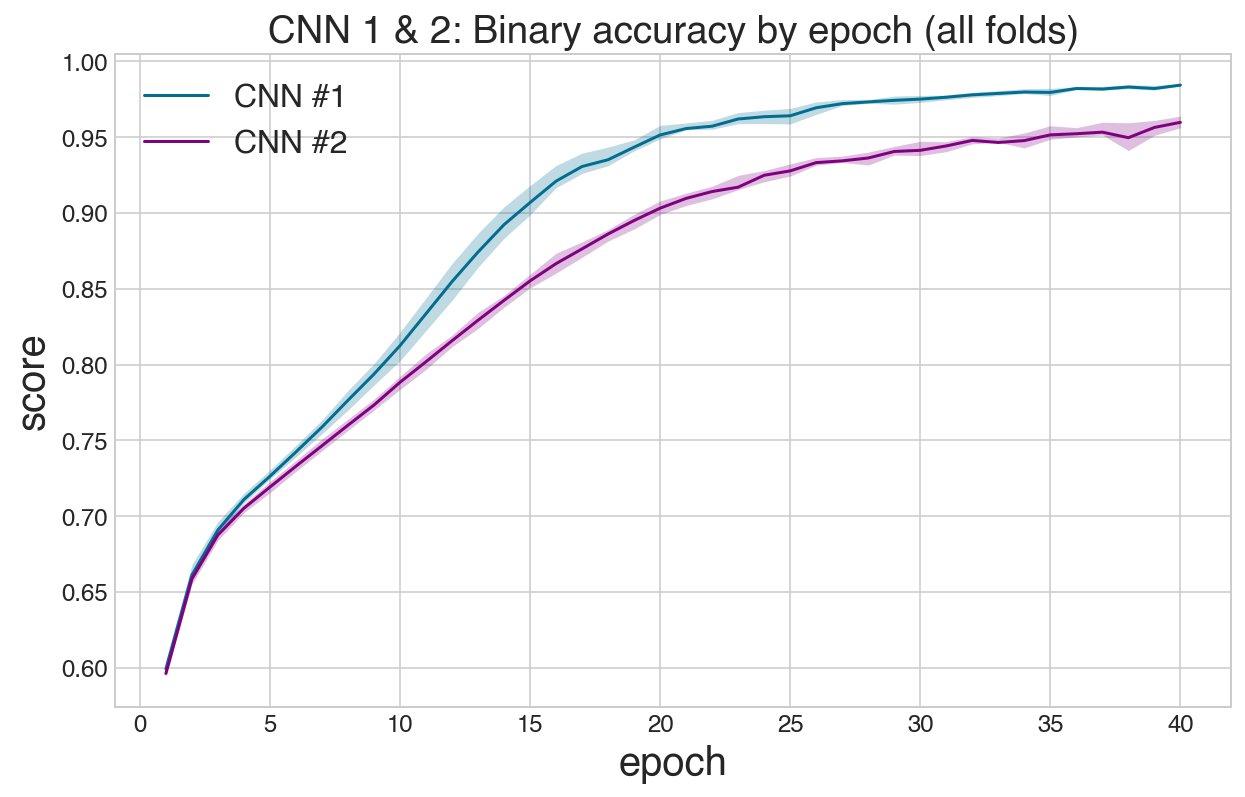

In [153]:
average_line(accs)
average_line(cnn2_accs, color='purple')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(labels=['CNN #1','CNN #2'])
plt.title('CNN 1 & 2: Binary accuracy by epoch (all folds)');

Below, we see an apples-to-apples comparison of the final ROC/AUC scores for each of ten randomized and stratified folds of cross-validation for the two CNN architectures and the (mostly untuned) MLP. We believe the MLP could be improved upon with basic tweaking, and furthermore that it would still represent a viable time-performance tradeoff for some use cases. However, we are very satisfied with the high performance of our CNN, especially the carefully adjusted first architecture. 97% accuracy is nothing to scoff at, and the low interfold variance is a good sign that our dataset is sufficiently large/diverse, and that the model is not susceptible to different subsets of data (at least, at this scale of dataset).

If the CNN were trained half as long (20 minutes) and not cross validated (simply trained once), it would happen sufficiently fast for many use cases, but only on a sufficiently powerful compute platform, and at sufficient energy expense. On the other hand, if we trained this model for 100 epochs, we may approach 99% accuracy, but it would be difficult to determine if we were overfitting at that point without some more information.


Accuracy (ROC)

CNN #1: 0.97 (±%0.014)
CNN #2: 0.92 (±%0.037)
MLP: 0.7 (±%0.017)



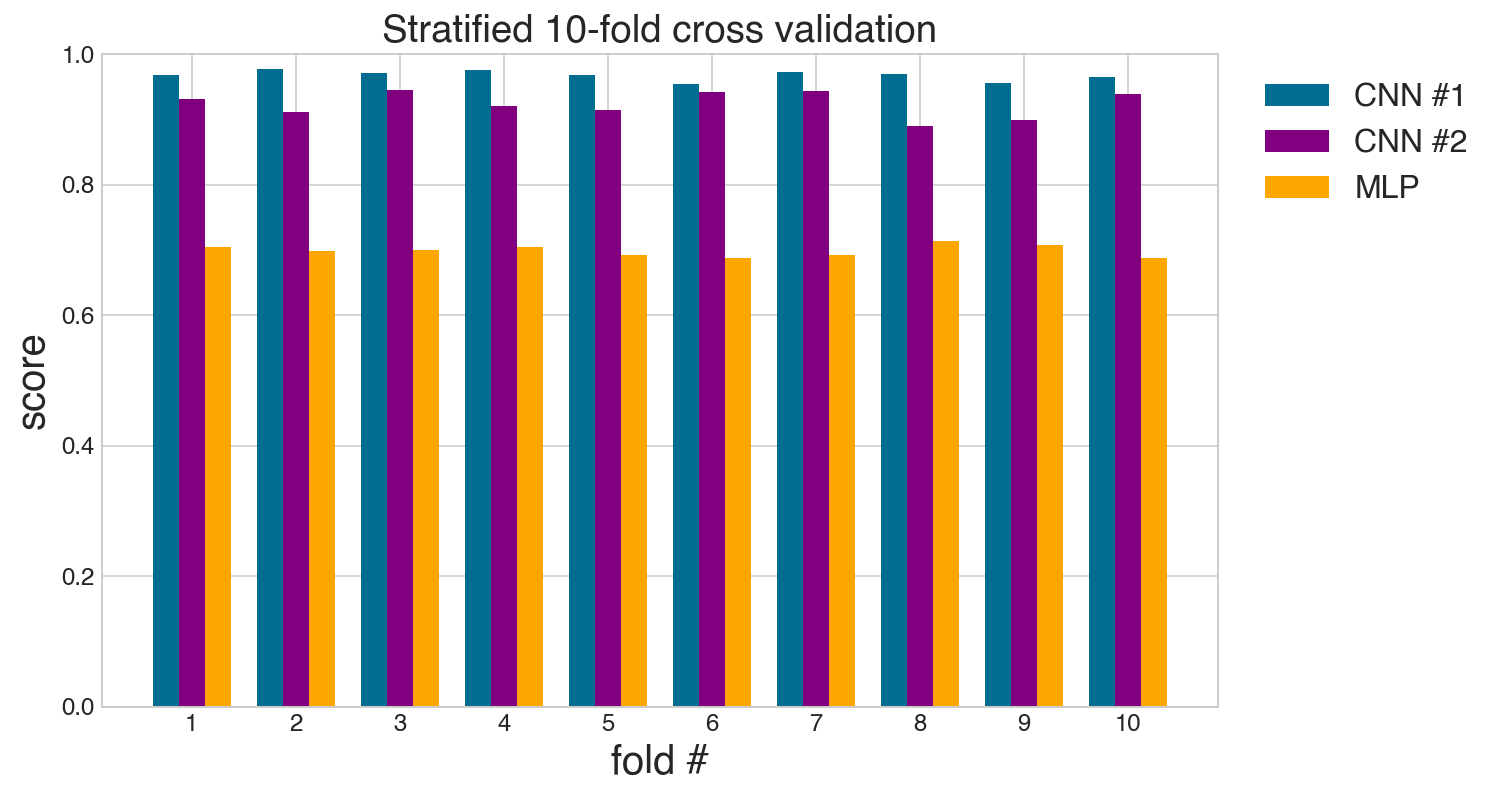

In [152]:
graph_cv_compare([scores, cnn2_scores, mlp_scores], 
    names=['CNN #1', 'CNN #2', 'MLP'], 
    colors=['#016d91', 'purple', 'orange']
)

In [176]:
sess.close()

In conclusion, we are very satisfied with the performance of our CNN on this prediction task for a particularly unfriendly dataset. We are certain that there is room for improvement through tuning but wouldn't be certain, at this point, of our approach towards hyperparameter tuning other than basic guessing, trial and error. Through hardware and design improvements we have shortened execution time to a short enough period that tweaking is feasible, but need more direction on a deterministic methodology for tuning before we move ahead with it.

This lab was a great opportunity for both Jake and I to learn much more about CNNs, but moreover to learn how to properly design the code to support long-running compute operations, by caching expensive operations like cross-validation and data processing to file to speed up kernel re-runs. We learned how to optimize bottlenecks in data preparation and other areas outside of our models *per se*, namely being able to speed up normalization by a factor of ten by moving it to the GPU instead of relying on Numpy. These improvements are not earth-shattering, but are small quality-of-life improvements when reexecuting the notebook voluntarily or upon kernel failure. This has lent us some perspective on how to plan for codebases that run very expensive and fragile operations in the future.